In [1]:
import pandas as pd
import os

def load_and_merge_excels(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.xlsx')]
    df_list = [pd.read_excel(file) for file in all_files]
    merged_df = pd.concat(df_list, ignore_index=True)
    return merged_df  

otodom_folder = r'otodom\data_archive'
domiporta_folder = r'domiporta\data_archive'
otodom_df = load_and_merge_excels(otodom_folder)
domiporta_df = load_and_merge_excels(domiporta_folder)
otodom_df = otodom_df.drop_duplicates(subset='URL', keep='last')
domiporta_df = domiporta_df.drop_duplicates(subset='URL', keep='last')

In [2]:
def joindf(otodom_df, domiporta_df):
    otodom_df.rename(columns={
        'Cena za m²': 'Cena za m2',
        'Wielkość': 'Powierzchnia całkowita',
        'Rodzaj zabudowy': 'Typ budynku',
        'Materiał budynku': 'Materiał',
        'Czynsz': 'Czynsz administracyjny',
        'Ogrzewanie' : 'ogrzewanie',
        'Winda' : 'winda'
    }, inplace=True)

    domiporta_df.rename(columns={
        'garaż_łącznie' : 'garaż',
        'ogrzewanie_łącznie' : 'ogrzewanie',
        'balkon_łącznie' : 'balkon',
        'miejsce_prakingowe_łącznie' : 'miejsce parkingowe',
        'Informacje dodatkowe:': 'Informacje dodatkowe',
        'Liczba pięter w budynku' : 'Liczba pięter'
    }, inplace=True)
    combined_df = pd.concat([otodom_df, domiporta_df], ignore_index=True)
    return combined_df


In [3]:
def imputeDisctrits(combined_df):
    districts_df = pd.read_excel(r'ulice_dzielnice_Katowic.xlsx')
    for i, row in combined_df.iterrows():
        if row['dzielnica'] == 'brak informacji': 
            for _, district_row in districts_df.iterrows():
                if district_row['Street'] and pd.notnull(row['ulica']) and district_row['Street'].lower() in row['ulica'].lower():
                    combined_df.loc[i, 'dzielnica'] = district_row['District']
                    break  
            else:
                combined_df.loc[i, 'dzielnica'] = 'brak informacji' 
    combined_df = combined_df[~combined_df['dzielnica'].isna() & (combined_df['dzielnica'] != 'brak informacji')]
    return combined_df


In [4]:
import numpy as np
districts_distance_map = {
    'Centrum': 1,
    'Śródmieście': 1,
    'Koszutka': 1,
    'Bogucice': 1,
    'Os. Paderewskiego': 2,
    'Muchowiec': 2,
    'Załęże': 2,
    'Osiedle Wincentego Witosa': 2,
    'Witosa': 2,
    'Osiedle Tysiąclecia': 2,
    'Dąb': 3,
    'Wełnowiec-Józefowiec': 3,
    'Józefowiec': 3,
    'Ligota-Panewniki': 3,
    'Ligota': 3,
    'Brynów-Osiedle Zgrzebnioka': 3,
    'Brynów': 3,
    'Załęska Hałda': 4,
    'Brynów': 4,
    'Zawodzie': 4,
    'Dąbrówka Mała': 4,
    'Szopienice-Burowiec': 4,
    'Szopienice': 4,
    'Janów-Nikiszowiec': 5,
    'Nikiszowiec': 5,
    'Giszowiec': 5,
    'Murcki': 5,
    'Piotrowice-Ochojec': 5,
    'Piotrowice': 5,
    'Ochojec': 5,
    'Zarzecze': 5,
    'Kostuchna': 5,
    'Podlesie': 5
}

def map_district_with_contains(dzielnica):
    for part in districts_distance_map:
        if part in dzielnica: 
            return districts_distance_map[part]
    return np.nan  

In [5]:
def data_preprocessed(otodom_df, domiporta_df):
    combined_df = joindf(otodom_df, domiporta_df)
    combined_df = imputeDisctrits(combined_df)
    combined_df['dzielnica_num'] = combined_df['dzielnica'].apply(map_district_with_contains)
    return combined_df

In [6]:
from datetime import date
data = date.today()
combined_df = data_preprocessed(otodom_df, domiporta_df)
combined_df_to_save = combined_df.drop(columns=['Powierzchnia piwnicy', 'Kategoria', 'Bezpieczeństwo', 'Zabezpieczenia', 'Czynsz administracyjny', 'Materiał', 'pom. użytkowe', 'taras', 'Informacje dodatkowe'])
combined_df_to_save.to_excel(f'archive_data\Data_all_preprocessed_{data}.xlsx', index=False)

In [7]:
otodom_actual = pd.read_excel(f'otodom\data_archive\otodom_data_preprocess_{data}.xlsx')
domiporta_actual = pd.read_excel(f'domiporta\data_archive\domiporta_data_preprocess_{data}.xlsx')
combined_df_actual = data_preprocessed(otodom_actual, domiporta_actual)
combined_df_to_save_actual = combined_df_actual.drop(columns=['Powierzchnia piwnicy', 'Kategoria', 'Bezpieczeństwo', 'Zabezpieczenia', 'Czynsz administracyjny', 'Materiał', 'pom. użytkowe', 'taras', 'Informacje dodatkowe'])
combined_df_to_save_actual.to_excel(f'Data_all_preprocessed_actual.xlsx', index=False)

In [8]:
combined_df_to_save.isnull().sum().sort_values(ascending=False)

Ogłoszeniodawca           5730
Typ budynku               2250
Rok budowy                1451
ulica                     1387
Typ ogłoszeniodawcy       1227
Rynek                     1227
Ogrzewanie_rodzaj         1227
Stan wykończenia          1227
Dostępne od                898
Forma własności            621
Liczba pięter              259
Piętro                      53
Liczba pokoi                 0
URL                          0
Lokalizacja                  0
Powierzchnia całkowita       0
Cena                         0
Cena za m2                   0
ogrzewanie                   0
województwo                  0
winda                        0
miasto                       0
dzielnica                    0
balkon                       0
piwnica                      0
miejsce parkingowe           0
garaż                        0
ochrona                      0
dzielnica_num                0
dtype: int64

                            Cena  Powierzchnia całkowita  Liczba pokoi  \
Cena                    1.000000                0.679618      0.566912   
Powierzchnia całkowita  0.679618                1.000000      0.719146   
Liczba pokoi            0.566912                0.719146      1.000000   
Piętro                  0.180243               -0.029304     -0.063436   
Rok budowy              0.042174               -0.023878     -0.011707   
winda                   0.142623               -0.105981     -0.085882   
ogrzewanie             -0.069599                0.068418      0.122022   
Liczba pięter           0.141962               -0.101149     -0.126906   
balkon                 -0.014053                0.032718      0.099001   
piwnica                -0.182613                0.051434      0.076795   
garaż                   0.159726               -0.004662     -0.029852   
miejsce parkingowe      0.155373               -0.018864     -0.039550   
ochrona                 0.060534      

<Axes: >

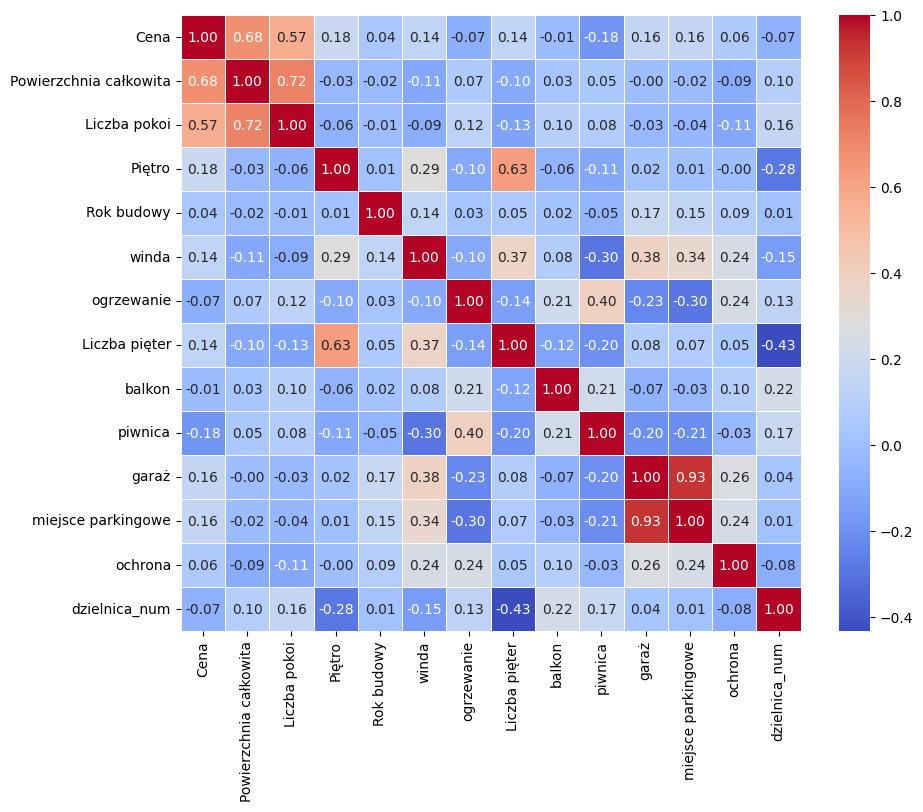

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
combined_df_to_save_num = combined_df_to_save.drop(columns=['Cena za m2', 'Lokalizacja', 'Typ budynku', 'Typ ogłoszeniodawcy', 'URL', 'Forma własności', 'Dostępne od', 'Stan wykończenia', 'województwo', 'dzielnica', 'ulica', 'miasto', 'Ogłoszeniodawca', 'Rynek', 'Ogrzewanie_rodzaj'])
correlation_matrix = combined_df_to_save_num.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [10]:
combined_df_preprocess = combined_df[['Cena za m2', 'Powierzchnia całkowita', 'Liczba pokoi', 'Piętro', 'Liczba pięter', 'garaż', 'miejsce parkingowe', 'dzielnica_num']]

<Figure size 1200x800 with 0 Axes>

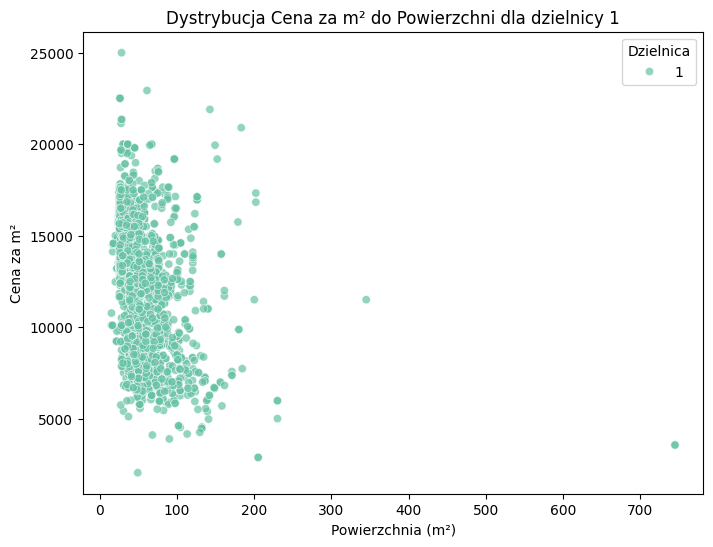

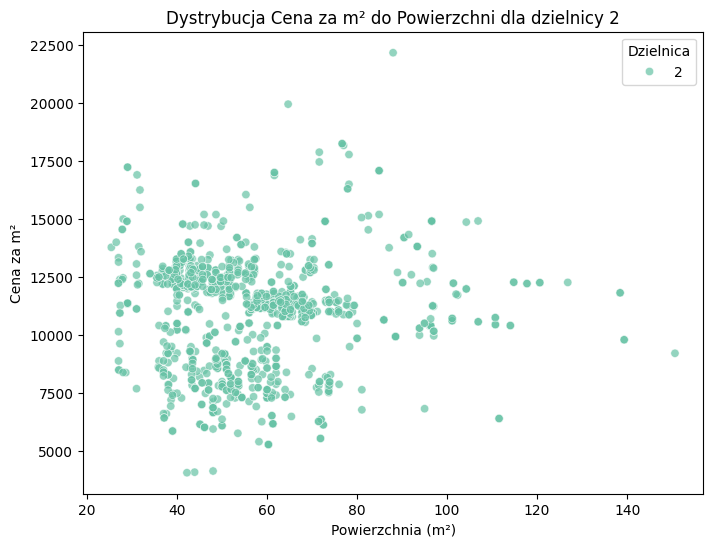

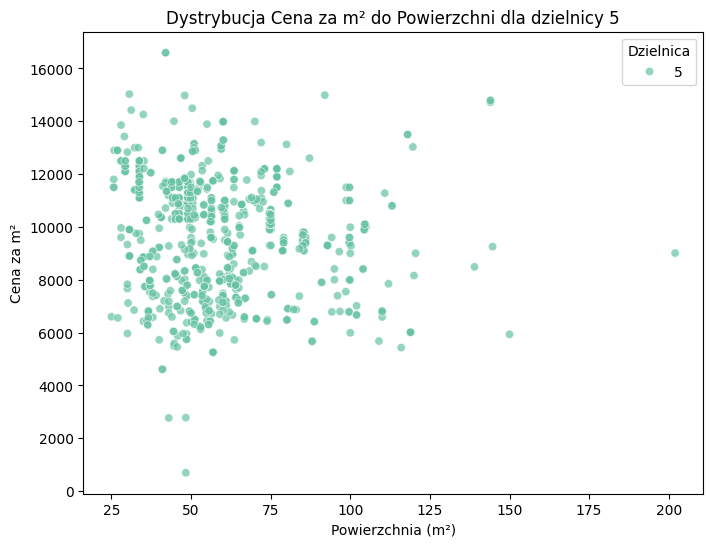

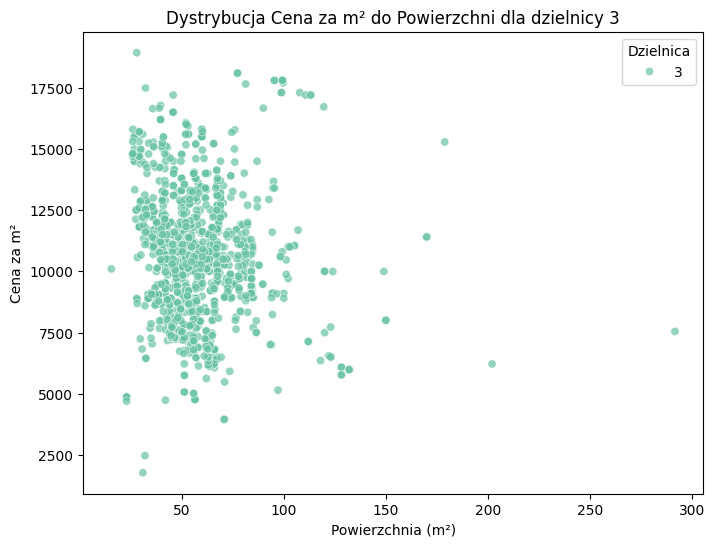

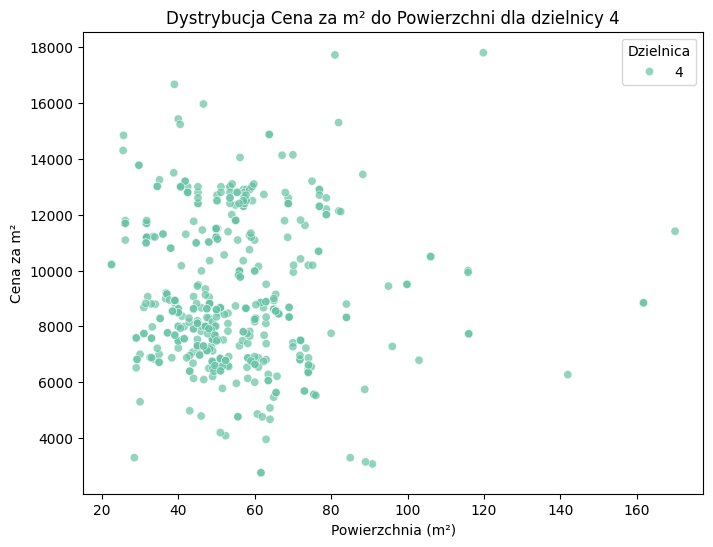

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
unique_dzielnice = combined_df_preprocess['dzielnica_num'].unique()
plt.figure(figsize=(12, 8))
for dzielnica in unique_dzielnice:
    subset = combined_df_preprocess[combined_df_preprocess['dzielnica_num'] == dzielnica]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=subset, x='Powierzchnia całkowita', y='Cena za m2', hue='dzielnica_num', palette='Set2', alpha=0.7)
    plt.title(f"Dystrybucja Cena za m² do Powierzchni dla dzielnicy {dzielnica}")
    plt.xlabel("Powierzchnia (m²)")
    plt.ylabel("Cena za m²")
    plt.legend(title="Dzielnica", loc='upper right')
    plt.show()


In [12]:
columns_to_check = ['Cena za m2', 'Powierzchnia całkowita'] 
outliers = pd.DataFrame()

for col in columns_to_check:
    Q1 = combined_df_preprocess[col].quantile(0.25)
    Q3 = combined_df_preprocess[col].quantile(0.75) 
    IQR = Q3 - Q1 

    col_outliers = combined_df_preprocess[(combined_df_preprocess[col] < Q1 - 1.5 * IQR) | (combined_df_preprocess[col] > Q3 + 1.5 * IQR)] 
    
    outliers = pd.concat([outliers, col_outliers])

outliers = outliers.drop_duplicates()
outliers

,Cena za m2,Powierzchnia całkowita,Liczba pokoi,Piętro,Liczba pięter,garaż,miejsce parkingowe,dzielnica_num
50,19969.00,32.50,1,10.0,17.0,0,0,1
562,19881.00,35.16,2,10.0,26.0,1,1,1
658,20000.00,30.00,1,2.0,11.0,0,0,1
663,2758.00,61.64,3,NaN,NaN,0,0,4
677,2778.00,48.35,2,NaN,NaN,0,0,5
...,...,...,...,...,...,...,...,...
7011,6270.70,141.93,2,1.0,4.0,1,0,1
7021,7368.42,171.00,3,7.0,8.0,0,0,1
7049,6657.89,114.00,3,2.0,4.0,0,0,1
7055,5772.23,128.20,4,0.0,NaN,0,0,3


In [13]:
combined_df_preprocess = combined_df_preprocess[~combined_df_preprocess.apply(tuple, 1).isin(outliers.apply(tuple, 1))]

In [14]:
combined_df_preprocess = combined_df_preprocess.dropna()

In [15]:
#combined_df_preprocess = pd.get_dummies(combined_df_preprocess, columns=['dzielnica_num'], prefix='dzielnica_num')

                        Cena za m2  Powierzchnia całkowita  Liczba pokoi  \
Cena za m2                1.000000               -0.316274     -0.329764   
Powierzchnia całkowita   -0.316274                1.000000      0.827679   
Liczba pokoi             -0.329764                0.827679      1.000000   
Piętro                    0.355805               -0.067025     -0.087884   
Liczba pięter             0.414294               -0.111981     -0.131542   
garaż                     0.365101                0.009268     -0.033076   
miejsce parkingowe        0.383419               -0.009613     -0.044810   
dzielnica_num            -0.403081                0.193960      0.197171   

                          Piętro  Liczba pięter     garaż  miejsce parkingowe  \
Cena za m2              0.355805       0.414294  0.365101            0.383419   
Powierzchnia całkowita -0.067025      -0.111981  0.009268           -0.009613   
Liczba pokoi           -0.087884      -0.131542 -0.033076           -0.0

<Axes: >

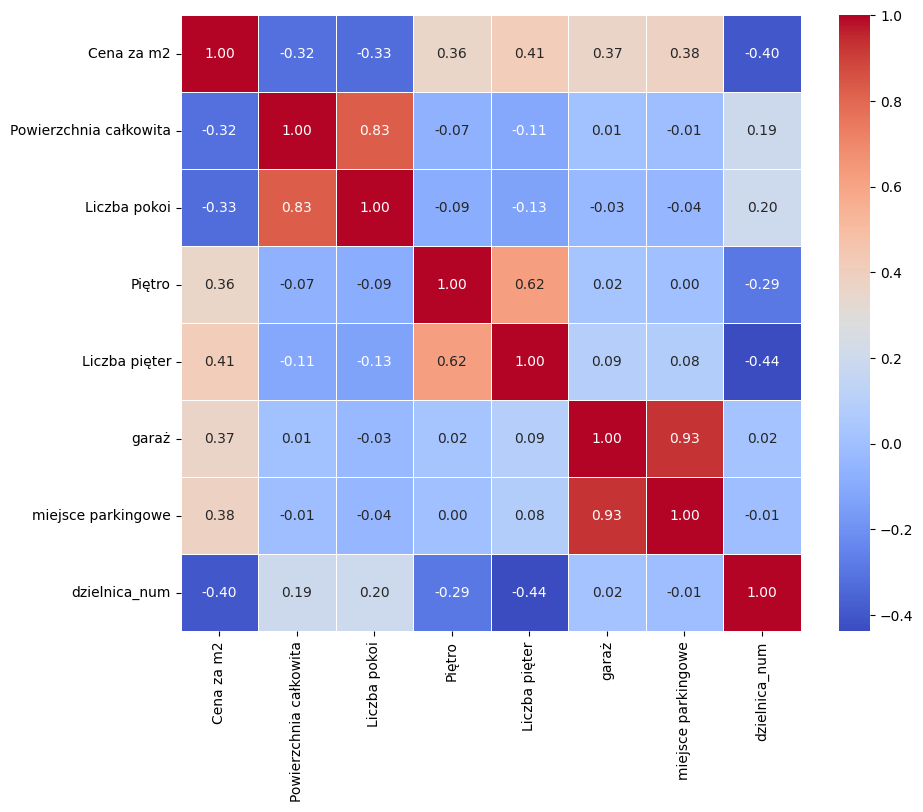

In [16]:
correlation_matrix = combined_df_preprocess.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [17]:
combined_df_preprocess.isnull().sum().sort_values(ascending = False)

Cena za m2                0
Powierzchnia całkowita    0
Liczba pokoi              0
Piętro                    0
Liczba pięter             0
garaż                     0
miejsce parkingowe        0
dzielnica_num             0
dtype: int64

In [18]:
combined_df_preprocess['dzielnica_num'].value_counts()

dzielnica_num
1    2902
3    1351
2    1003
5     700
4     457
Name: count, dtype: int64

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = combined_df_preprocess
X = df.drop(['Cena za m2'], axis=1)
y = df['Cena za m2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Machine": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "LinearRegression" : LinearRegression()
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        #("scaler", StandardScaler()),  # Skalowanie danych
        ("regressor", model) 
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = pipeline.score(X_test, y_test)
    results[name] = {
        "score": score
    }

for model, metrics in results.items():
    print(f"Model: {model}")
    print(f" Score: {metrics['score']} ")
    print("-" * 30)


Model: Random Forest
 Score: 0.7924985340762275 
------------------------------
Model: Gradient Boosting
 Score: 0.6341977878139369 
------------------------------
Model: Support Vector Machine
 Score: 0.06251713141102444 
------------------------------
Model: K-Nearest Neighbors
 Score: 0.6453372639785292 
------------------------------
Model: LinearRegression
 Score: 0.4676024721973894 
------------------------------


In [21]:
best_model_name = "Random Forest"
best_model = models[best_model_name]

pipeline = Pipeline([
    #("scaler", StandardScaler()), 
    ("regressor", best_model)
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('regressor', RandomForestRegressor(random_state=42))])

In [22]:
new_data = pd.DataFrame({
    'Powierzchnia całkowita': [30],
    'Liczba pokoi': [2],
    'Piętro': [1],
    'Liczba pięter': [4],
    'garaż': [0],
    'miejsce parkingowe': [1],
    'dzielnica_num': [5]
})
y_new_pred = pipeline.predict(new_data)
print(f"Przewidywana cena: {y_new_pred[0]}")

Przewidywana cena: 12548.363299999999


In [23]:
import joblib
joblib.dump(pipeline, 'django\realestate\model.pkl')

['model.pkl']